# Gold Return and Directional Movement Prediction 

## 1. Obtain data and pre-process 

In [108]:
# Importing libraries
import pandas as pd
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pycaret.regression import *
import time
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)
import traceback
from itertools import combinations
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from scipy.stats import entropy

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score
)

The ticker_list contains the ticker symbols and their descriptions

In [33]:
ticker_details = pd.read_excel('./data/ticker_list.xlsx')
ticker_details.head(20)

,Ticker,Description
0,GC=F,Gold
1,SI=F,Silver
2,CL=F,Crude Oil
3,^GSPC,S&P500
4,^RUT,Russel 2000 Index
5,ZN=F,10 Yr US T-Note futures
6,ZT=F,2 Yr US T-Note Futures
7,PL=F,Platinum
8,HG=F,Copper
9,DX=F,Dollar Index


Geopolitical index is pre-downloaded from https://www.matteoiacoviello.com/gpr.htm

In [34]:
geo_political_df = pd.read_excel('./data/gpr_geopolitical.xls', usecols=['date', 'GPRD'])
geo_political_df.columns = ['Gpr', 'Date']
geo_political_df.head(3)

,Gpr,Date
0,230.039429,1985-01-01
1,115.676971,1985-01-02
2,97.428459,1985-01-03


In [35]:
ticker = ticker_details['Ticker'].to_list()
names = ticker_details['Description'].to_list()

In [36]:
# Define the range to download data from Yahoo Finance 
end_date= "2025-10-30"
start_date = "2010-01-01"
date_range = pd.bdate_range(start=start_date,end=end_date)
values = pd.DataFrame({ 'Date': date_range})
values['Date']= pd.to_datetime(values['Date'])

In [37]:
# Download data from Yahoo Finance
for i in ticker:

    raw_data = yf.download(i, start=start_date, end=end_date, progress=False, auto_adjust=True)[['Close']]
    raw_data.reset_index(inplace=True)
    raw_data.columns = ['Date',i]
    values = values.merge(raw_data,how='left',left_on='Date',right_on='Date')

# Rename columns to represent instrument names rather than their ticker codes for ease of readability
names.insert(0,'Date')
values.columns = names
print(values.shape)
print(values.isna().sum())
values.tail()

(4130, 17)
Date                         0
Gold                       150
Silver                     150
Crude Oil                  149
S&P500                     149
Russel 2000 Index          149
10 Yr US T-Note futures    150
2 Yr US T-Note Futures     148
Platinum                   151
Copper                     149
Dollar Index               148
Volatility Index           149
Soybean                    150
MSCI EM ETF                149
Euro USD                     9
Euronext100                 82
Nasdaq                     149
dtype: int64


,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
4125,2025-10-24,4118.399902,48.376999,61.500000,6791.689941,2513.469971,113.437500,104.382812,1593.900024,5.0935,98.747002,16.370001,1041.75,54.322609,1.161805,1714.550049,23204.869141
4126,2025-10-27,4001.899902,46.562000,61.310001,6875.160156,2520.439941,113.421875,104.347656,1578.400024,5.1405,98.563004,15.790000,1067.25,54.924004,1.163169,1720.630005,23637.460938
4127,2025-10-28,3966.199951,47.125000,60.150002,6890.890137,2506.649902,113.468750,104.347656,1577.000000,5.1405,98.453003,16.420000,1078.25,54.904285,1.165175,1716.979980,23827.490234
4128,2025-10-29,3983.699951,47.721001,60.480000,6890.589844,2484.810059,112.906250,104.179688,1591.300049,5.2335,99.022003,16.920000,1080.25,55.219769,1.165787,1719.479980,23958.470703
4129,2025-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Merge geopolitical risk data
values = values.merge(geo_political_df, on = 'Date', how='left')
values = values.dropna()
values.tail()

,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq,Gpr
4124,2025-10-23,4125.500000,48.481998,61.790001,6738.439941,2482.659912,113.484375,104.390625,1587.599976,5.0820,98.728996,17.299999,1044.75,53.967690,1.160847,1714.209961,22941.800781,207.534378
4125,2025-10-24,4118.399902,48.376999,61.500000,6791.689941,2513.469971,113.437500,104.382812,1593.900024,5.0935,98.747002,16.370001,1041.75,54.322609,1.161805,1714.550049,23204.869141,164.843430
4126,2025-10-27,4001.899902,46.562000,61.310001,6875.160156,2520.439941,113.421875,104.347656,1578.400024,5.1405,98.563004,15.790000,1067.25,54.924004,1.163169,1720.630005,23637.460938,172.980026
4127,2025-10-28,3966.199951,47.125000,60.150002,6890.890137,2506.649902,113.468750,104.347656,1577.000000,5.1405,98.453003,16.420000,1078.25,54.904285,1.165175,1716.979980,23827.490234,155.404404
4128,2025-10-29,3983.699951,47.721001,60.480000,6890.589844,2484.810059,112.906250,104.179688,1591.300049,5.2335,99.022003,16.920000,1080.25,55.219769,1.165787,1719.479980,23958.470703,130.054611


In [40]:
#Front filling the NaN values in the data set

values = values.fillna(method="ffill",axis=0)
values = values.fillna(method="bfill",axis=0)
values.isna().sum()

/var/folders/2s/c91hjfkj4sz8smllrwvtr_c00000gn/T/ipykernel_98991/505582031.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  values = values.fillna(method="ffill",axis=0)
/var/folders/2s/c91hjfkj4sz8smllrwvtr_c00000gn/T/ipykernel_98991/505582031.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  values = values.fillna(method="bfill",axis=0)


Date                       0
Gold                       0
Silver                     0
Crude Oil                  0
S&P500                     0
Russel 2000 Index          0
10 Yr US T-Note futures    0
2 Yr US T-Note Futures     0
Platinum                   0
Copper                     0
Dollar Index               0
Volatility Index           0
Soybean                    0
MSCI EM ETF                0
Euro USD                   0
Euronext100                0
Nasdaq                     0
Gpr                        0
dtype: int64

In [41]:
# Coercing numeric type to all columns except Date

cols=values.columns.drop('Date')
values[cols] = values[cols].apply(pd.to_numeric,errors='coerce').round(decimals=1)
values.tail()

,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq,Gpr
4124,2025-10-23,4125.5,48.5,61.8,6738.4,2482.7,113.5,104.4,1587.6,5.1,98.7,17.3,1044.8,54.0,1.2,1714.2,22941.8,207.5
4125,2025-10-24,4118.4,48.4,61.5,6791.7,2513.5,113.4,104.4,1593.9,5.1,98.7,16.4,1041.8,54.3,1.2,1714.6,23204.9,164.8
4126,2025-10-27,4001.9,46.6,61.3,6875.2,2520.4,113.4,104.3,1578.4,5.1,98.6,15.8,1067.2,54.9,1.2,1720.6,23637.5,173.0
4127,2025-10-28,3966.2,47.1,60.2,6890.9,2506.6,113.5,104.3,1577.0,5.1,98.5,16.4,1078.2,54.9,1.2,1717.0,23827.5,155.4
4128,2025-10-29,3983.7,47.7,60.5,6890.6,2484.8,112.9,104.2,1591.3,5.2,99.0,16.9,1080.2,55.2,1.2,1719.5,23958.5,130.1


In [43]:
# Store the final dataset as csv
values.to_csv("./data/final_dataset.csv")

## 2. Feature Construction

I conduct two types of empirical analysis: regression and classification. The regression targets are the 7-, 14-, 21-, and 28-day ahead returns on gold futures, while the classification target is the corresponding directional movement. To capture short-term historical dynamics, I construct lagged values of order 1, 3, 7, 14, 21 and 28 for all variables. 

For a selected subset of variables, i.e. gold, silver, crude oil, the S\&P 500, the MSCI Emerging Markets ETF, the VIX, and the GPR index, I additionally include long-term historical returns at the 60-, 90-, 180-, and 250-day horizons.

In [56]:

# Calculating Short term Historical Returns

change_days = [1,3,7,14,21,28]

data = pd.DataFrame(data=values['Date'])
for i in change_days:
    print(data.shape)
    x= values[cols].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

# Calculating Long term Historical Returns for some specific explanatory variables
change_days = [60,90,180,250]

imp = ['Gold','Silver', 'Crude Oil', 'S&P500','MSCI EM ETF', 'Volatility Index' ,'Gpr']

for i in change_days:
    print(data.shape)
    x= values[imp].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

(3929, 1)
(3929, 18)
(3929, 35)
(3929, 52)
(3929, 69)
(3929, 86)
(3929, 103)
(3929, 103)
(3929, 110)
(3929, 117)
(3929, 124)
(3929, 131)



Simple moving averages with 15-, 30-, 60-, 90-, and 180-day windows, and exponentially weighted moving averages with 90- and 180-day spans of gold returns.


In [57]:
moving_avg = pd.DataFrame(values['Date'],columns=['Date'])
moving_avg['Date']=pd.to_datetime(moving_avg['Date'],format='%Y-%b-%d')
moving_avg['Gold/15SMA'] = (values['Gold']/(values['Gold'].rolling(window=15).mean()))-1
moving_avg['Gold/30SMA'] = (values['Gold']/(values['Gold'].rolling(window=30).mean()))-1
moving_avg['Gold/60SMA'] = (values['Gold']/(values['Gold'].rolling(window=60).mean()))-1
moving_avg['Gold/90SMA'] = (values['Gold']/(values['Gold'].rolling(window=90).mean()))-1
moving_avg['Gold/180SMA'] = (values['Gold']/(values['Gold'].rolling(window=180).mean()))-1
moving_avg['Gold/90EMA'] = (values['Gold']/(values['Gold'].ewm(span=90,adjust=True,ignore_na=True).mean()))-1
moving_avg['Gold/180EMA'] = (values['Gold']/(values['Gold'].ewm(span=180,adjust=True,ignore_na=True).mean()))-1
moving_avg = moving_avg.dropna(axis=0)
print(moving_avg.shape)
moving_avg.head()

(3750, 8)


,Date,Gold/15SMA,Gold/30SMA,Gold/60SMA,Gold/90SMA,Gold/180SMA,Gold/90EMA,Gold/180EMA
187,2010-09-21,0.010804,0.024644,0.043380,0.042369,0.083155,0.044619,0.060038
188,2010-09-22,0.022675,0.036363,0.057225,0.056347,0.097412,0.057830,0.073842
189,2010-09-23,0.023329,0.036969,0.059827,0.059062,0.099984,0.059741,0.076195
190,2010-09-24,0.022276,0.036084,0.060488,0.059666,0.100596,0.059684,0.076546
191,2010-09-27,0.020279,0.034389,0.059755,0.059237,0.100342,0.058831,0.076074


In [58]:
# Merge Moving Average values to the feature space
print(data.shape)
data['Date']=pd.to_datetime(data['Date'],format='%Y-%b-%d')
data = pd.merge(left=data,right=moving_avg,how='left',on='Date')
print(data.shape)
data.isna().sum()

(3929, 131)
(3929, 138)


Date               0
Gold-T-1           1
Silver-T-1         1
Crude Oil-T-1      1
S&P500-T-1         1
                ... 
Gold/60SMA       179
Gold/90SMA       179
Gold/180SMA      179
Gold/90EMA       179
Gold/180EMA      179
Length: 138, dtype: int64

In [59]:
# Target Creation

y = pd.DataFrame(data=values['Date'])
print(y.shape)
y['Gold-T+7']=values['Gold'].pct_change(periods=-7)
y['Gold-T+14']=values["Gold"].pct_change(periods=-14)
y['Gold-T+21']=values["Gold"].pct_change(periods=-21)
y['Gold-T+28']=values["Gold"].pct_change(periods=-28)
print(y.shape)
y.isna().sum()

(3929, 1)
(3929, 5)


Date          0
Gold-T+7      7
Gold-T+14    14
Gold-T+21    21
Gold-T+28    28
dtype: int64

In [60]:
# Remove NAs
print(data.shape)
data = data[data['Gold-T-250'].notna()]
y = y[y['Gold-T+28'].notna()]
print(data.shape)
print(y.shape)

(3929, 138)
(3679, 138)
(3901, 5)


Now we will merge the Target variables with the feature space to get a data whcih we can finally start modelling on.

In [61]:
# Add Target Variables
data = pd.merge(left=data,right=y,how='inner',on='Date',suffixes=(False,False))
print(data.shape)
data.isna().sum()

(3651, 142)


Date             0
Gold-T-1         0
Silver-T-1       0
Crude Oil-T-1    0
S&P500-T-1       0
                ..
Gold/180EMA      0
Gold-T+7         0
Gold-T+14        0
Gold-T+21        0
Gold-T+28        0
Length: 142, dtype: int64

Plot targets to identify trends

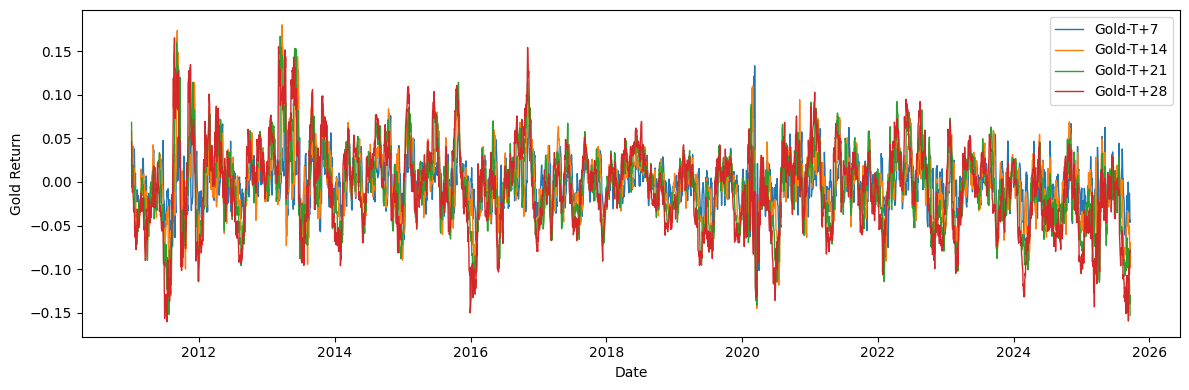

In [82]:
targets = ['Gold-T+7','Gold-T+14','Gold-T+21','Gold-T+28']

plt.figure(figsize=(12,4))
for tgt in targets:
    plt.plot(data['Date'], data[tgt], label=tgt, linewidth=1)

plt.xlabel('Date')
plt.ylabel('Gold Return')
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()


Feature-target correlation correlation

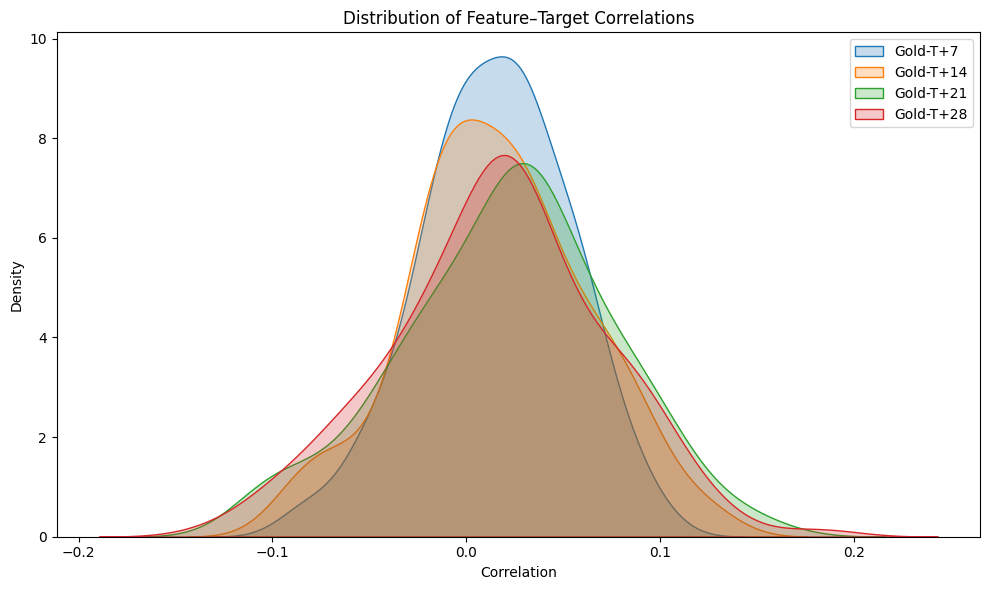

In [85]:

targets = ['Gold-T+7','Gold-T+14','Gold-T+21','Gold-T+28']

# Identify feature names
features = [c for c in data.columns if c not in ['Date'] + targets]

# Compute correlations
corr_dict = {}
for tgt in targets:
    corr_dict[tgt] = data[features].corrwith(data[tgt]).dropna().values

# Plot
plt.figure(figsize=(10,6))
for tgt in targets:
    sns.kdeplot(corr_dict[tgt], label=tgt, fill=True, alpha=0.25)

plt.title('Distribution of Feature–Target Correlations')
plt.xlabel('Correlation')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()


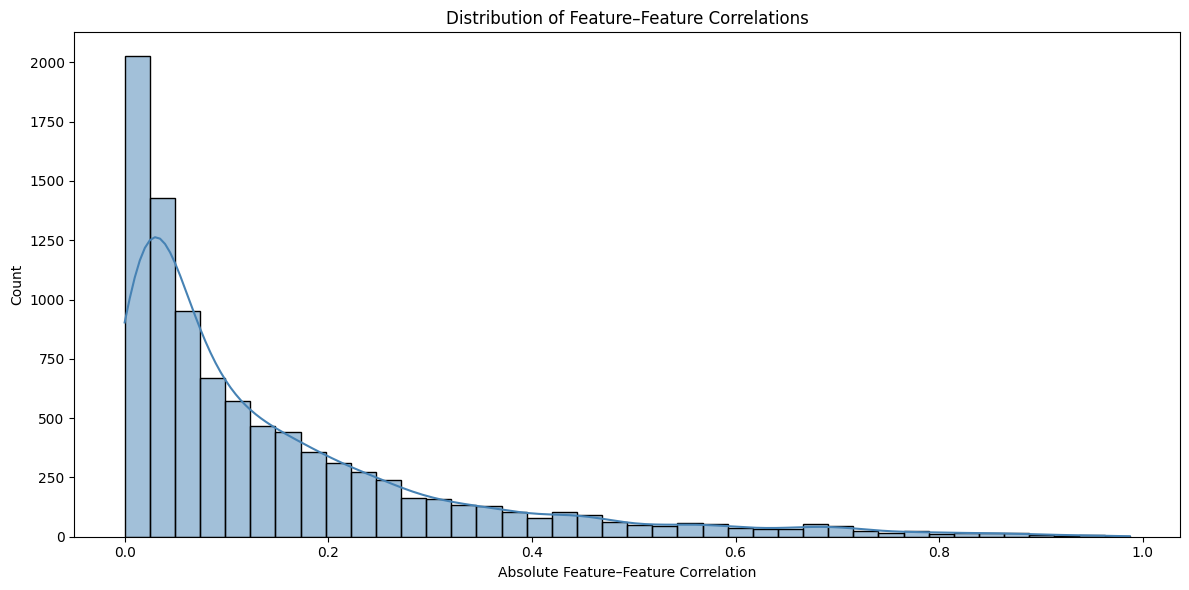

In [87]:

# Compute pairwise feature correlations
corr_matrix = data[features].corr().values

# Extract upper-triangle values (excluding diagonal)
vals = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]

# Take absolute correlations
vals = np.abs(vals)

plt.figure(figsize=(12,6))
sns.histplot(vals, bins=40, kde=True, color='steelblue')
plt.title('Distribution of Feature–Feature Correlations')
plt.xlabel('Absolute Feature–Feature Correlation')
plt.ylabel('Count')
plt.tight_layout()
plt.grid(False)
plt.show()


In [88]:
median_ff = np.median(np.abs(vals))
median_ff

0.08245701229102757

## 3. Regression Analysis

In [91]:
# ------------ CONFIG ----------------
targets = ['Gold-T+7','Gold-T+14','Gold-T+21','Gold-T+28']

candidate_models = [
    'ridge',
    'et',
    'rf',
    'gbr',
    'catboost',
    'xgboost',
    'mlp'
]

WINDOW_YEARS = 4
MIN_TRAIN_ROWS = 150
SESSION_ID = 123

# -----------------------------------------
def make_df(data, tgt, targets):
    df = data.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.dropna(subset=[tgt])
    df = df.sort_values('Date')

    df['year']      = df['Date'].dt.year
    df['month']     = df['Date'].dt.month
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['dayofyear'] = df['Date'].dt.dayofyear

    others = [c for c in targets if c != tgt]
    df = df.drop(columns=others, errors='ignore')
    return df.reset_index(drop=True)


# -----------------------------------------
def extract_preds(preds_df):
    if 'Label' in preds_df.columns:
        return preds_df['Label'].values
    if 'prediction_label' in preds_df.columns:
        return preds_df['prediction_label'].values
    raise ValueError(f"No prediction column found in {preds_df.columns}")


# -----------------------------------------
# WALK-FWD EVAL
# -----------------------------------------
def yearly_rolling_walk_forward(
    model_name:str,
    df:pd.DataFrame,
    target:str,
    window_years:int=3,
    tuning:bool=False
):
    df = df.copy()
    years = sorted(df['year'].unique())
    full_feats = [c for c in df.columns if c not in ['Date', target]]

    results = []
    pred_store = []
    total_start = time.time()

    for test_year in years:

        train_start_year = test_year - window_years
        if train_start_year < years[0]:
            continue

        train = df[(df['year'] >= train_start_year) & (df['year'] < test_year)]
        test  = df[df['year'] == test_year]

        if len(train) < MIN_TRAIN_ROWS or len(test) < 10:
            continue

        train = train[['Date'] + full_feats + [target]].dropna()
        test  = test[['Date'] + full_feats + [target]].dropna()

        try:
            setup(
                data=train.drop(columns=['Date']),
                target=target,
                fold=3,
                fold_strategy='timeseries',
                data_split_shuffle=False,
                fold_shuffle=False,
                remove_outliers=False,
                verbose=False,
                session_id=SESSION_ID
            )

            start_train = time.time()

            base = create_model(model_name, verbose=False)
            if tuning:
                base = tune_model(base, optimize='RMSE', verbose=False)

            final_m = finalize_model(base)
            train_time = time.time() - start_train

            preds_df = predict_model(
                final_m,
                data=test.drop(columns=['Date']),
                verbose=False
            )

            preds  = extract_preds(preds_df)
            actual = test[target].values

            # save predictions
            pred_store_df = pd.DataFrame({
                'Date'      : test['Date'].values,
                'Target'    : target,
                'Model'     : model_name,
                'Test_Year' : test_year,
                'Actual'    : actual,
                'Predicted' : preds
            })
            pred_store.append(pred_store_df)

            # metrics
            r2   = r2_score(actual, preds)
            mse  = mean_squared_error(actual, preds)
            rmse = np.sqrt(mse)
            mae  = mean_absolute_error(actual, preds)

            results.append({
                'Model'                   : model_name,
                'Test_Year'               : test_year,
                'Train_Years'             : f"{train_start_year}–{test_year-1}",
                'Train_Rows'              : len(train),
                'Test_Rows'               : len(test),

                'Train_Time_Seconds'      : round(train_time, 4),

                'R2'                      : r2,
                'RMSE'                    : rmse,
                'MAE'                     : mae,

            })

        except Exception:
            print(f"\n⚠ ERROR: model={model_name}, Test_Year={test_year}")
            traceback.print_exc()

    total_run_time = time.time() - total_start

    df_res = pd.DataFrame(results)
    df_pred = pd.concat(pred_store, ignore_index=True) if pred_store else pd.DataFrame()

    df_res['Total_Run_Time_Seconds'] = round(total_run_time, 3)

    return df_res, df_pred


# -----------------------------------------
# MAIN EXECUTION
# -----------------------------------------
reg_summary_store = []
reg_full_results_store = []
reg_predictions_store = []

for tgt in targets:
    print(f"\n============== TARGET: {tgt} ==============")

    df_target = make_df(data, tgt, targets)

    for m in candidate_models:

        wf, preds = yearly_rolling_walk_forward(
            model_name=m,
            df=df_target,
            target=tgt,
            window_years=WINDOW_YEARS,
            tuning=True,
        )

        if len(wf):
            wf['Target'] = tgt
            wf['Model']  = m
            preds['Target'] = tgt

            reg_full_results_store.append(wf)
            reg_predictions_store.append(preds)

            avg_rmse  = wf['RMSE'].mean()
            avg_r2    = wf['R2'].mean()
            avg_ttime = wf['Train_Time_Seconds'].mean()
            total_run = wf['Total_Run_Time_Seconds'].iloc[0]
        else:
            avg_rmse = avg_r2 = avg_ttime = total_run = None

        reg_summary_store.append({
            'Target'                 : tgt,
            'Model'                  : m,
            'Avg_Rolling_RMSE'       : avg_rmse,
            'Avg_Rolling_R2'         : avg_r2,
            'Avg_Train_Time_Seconds' : avg_ttime,
            'Total_Run_Time_Seconds' : total_run,
            'Folds Evaluated'        : len(wf)
        })

        print(f"\n--- {tgt} | {m} RESULTS ---")
        print(wf)


# -----------------------------------------
# FINAL COMBINED DFs
# -----------------------------------------
reg_summary_df      = pd.DataFrame(reg_summary_store)
reg_full_results_df = pd.concat(reg_full_results_store, ignore_index=True)
reg_predictions_df  = pd.concat(reg_predictions_store, ignore_index=True)


print("\n============== REGRESSION SUMMARY TABLE ==============\n")
print(reg_summary_df)

print("\n============== REGRESSION FULL YEARLY RESULTS ==============\n")
print(reg_full_results_df)

print("\n============== REGRESSION PREDICTED VALUES ==============\n")
print(reg_predictions_df.head())




============== TARGET: Gold-T+7 ==============

--- Gold-T+7 | ridge RESULTS ---
    Model  Test_Year Train_Years  Train_Rows  Test_Rows  Train_Time_Seconds  \
0   ridge       2015   2011–2014         989        249              2.5445   
1   ridge       2016   2012–2015         987        247              2.4767   
2   ridge       2017   2013–2016         990        246              2.5506   
3   ridge       2018   2014–2017         988        247              2.6680   
4   ridge       2019   2015–2018         989        248              2.7263   
5   ridge       2020   2016–2019         988        251              2.5285   
6   ridge       2021   2017–2020         992        251              2.5584   
7   ridge       2022   2018–2021         997        250              2.6144   
8   ridge       2023   2019–2022        1000        247              2.5678   
9   ridge       2024   2020–2023         999        249              2.5136   
10  ridge       2025   2021–2024         997     

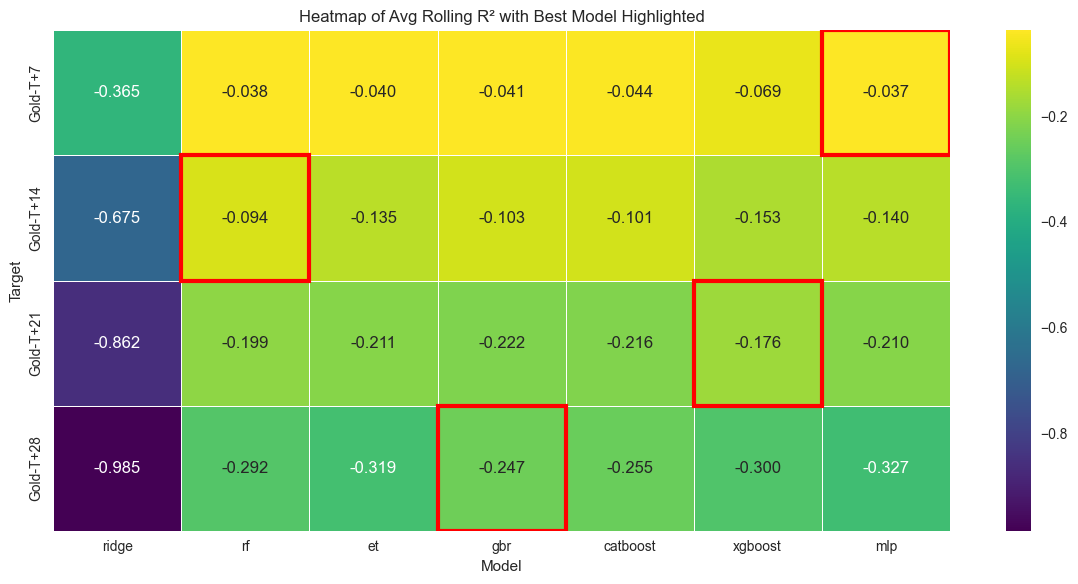

In [92]:
# Pivot
heatmap_df = reg_summary_df.pivot(
    index="Target",
    columns="Model",
    values="Avg_Rolling_R2"
)

# Correct target order
target_order = ["Gold-T+7", "Gold-T+14", "Gold-T+21", "Gold-T+28"]
heatmap_df = heatmap_df.reindex(target_order)

# Correct model order
model_order = ["ridge", "rf", "et", "gbr", "catboost", "xgboost", "mlp"]
heatmap_df = heatmap_df.reindex(columns=model_order)

# Create boolean mask of best models per row
best_mask = heatmap_df.eq(heatmap_df.max(axis=1), axis=0)
best_mask = best_mask.reindex(index=target_order, columns=model_order)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    linewidths=0.5
)

# Add red boxes around best values
for y in range(best_mask.shape[0]):
    for x in range(best_mask.shape[1]):
        if best_mask.iloc[y, x]:
            ax.add_patch(plt.Rectangle((x, y), 1, 1,
                                       fill=False, edgecolor='red', lw=3))

plt.title("Heatmap of Avg Rolling R² with Best Model Highlighted")
plt.ylabel("Target")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


In [93]:
reg_summary_df.to_csv('./result/reg_summary_df.csv')
reg_full_results_df.to_csv('./result/reg_full_results.csv')
reg_predictions_df.to_csv('./result/reg_pred_df.csv')


Emsemble Results 

In [95]:


reg_preds = reg_predictions_df.copy()

models = sorted(reg_preds['Model'].unique())
targets = sorted(reg_preds['Target'].unique())

ensemble_results = []

for tgt in targets:
    df_t = reg_preds[reg_preds['Target'] == tgt].copy()

    # pivot so columns are models and rows are prediction timepoints
    pred_mat = df_t.pivot_table(
        index=['Date'],
        columns='Model',
        values='Predicted'
    )

    # actual returns for target
    act = df_t[['Date','Actual']].drop_duplicates()
    pred_mat = pred_mat.merge(act, on='Date', how='left')

    for r in range(2, len(models)+1):
        for combo in combinations(models, r):

            # skip any combo that doesn't exist in this target
            if not set(combo).issubset(pred_mat.columns):
                continue

            # blended prediction: mean prediction
            pred_mat['Blend_Pred'] = pred_mat[list(combo)].mean(axis=1)

            actual = pred_mat['Actual'].values
            blended = pred_mat['Blend_Pred'].values

            # metrics
            mse  = mean_squared_error(actual, blended)
            rmse = np.sqrt(mse)
            mae  = mean_absolute_error(actual, blended)
            r2   = r2_score(actual, blended)

            ensemble_results.append({
                'Target'  : tgt,
                'Models'  : combo,
                'N_Models': len(combo),

                'RMSE' : rmse,
                'MAE'  : mae,
                'R2'   : r2,
            })

ensemble_df = pd.DataFrame(ensemble_results)

print("\n========== REGRESSION ENSEMBLE RESULTS (Mean Blend) ==========")
print(
    ensemble_df
    .sort_values(['Target','RMSE'], ascending=[True, True])
    .reset_index(drop=True)
)



========== REGRESSION ENSEMBLE RESULTS (Mean Blend) ==========
        Target                   Models  N_Models      RMSE       MAE  \
0    Gold-T+14      (catboost, et, gbr)         3  0.033358  0.026087   
1    Gold-T+14  (catboost, et, gbr, rf)         4  0.033358  0.026084   
2    Gold-T+14      (catboost, gbr, rf)         3  0.033371  0.026078   
3    Gold-T+14       (catboost, et, rf)         3  0.033372  0.026095   
4    Gold-T+14          (catboost, gbr)         2  0.033379  0.026082   
..         ...                      ...       ...       ...       ...   
475   Gold-T+7              (rf, ridge)         2  0.025055  0.019366   
476   Gold-T+7              (et, ridge)         2  0.025057  0.019359   
477   Gold-T+7             (gbr, ridge)         2  0.025072  0.019371   
478   Gold-T+7        (catboost, ridge)         2  0.025101  0.019398   
479   Gold-T+7         (ridge, xgboost)         2  0.025285  0.019563   

           R2  
0   -0.007629  
1   -0.007633  
2   -0.0084

In [97]:
# Check if any emsemble triggers positive R-squared

ensemble_df[ensemble_df['R2'] > 0]

,Target,Models,N_Models,RMSE,MAE,R2
375,Gold-T+7,"(mlp, rf)",2,0.02434,0.018507,0.000785


R-squared per target-model for each individual test year

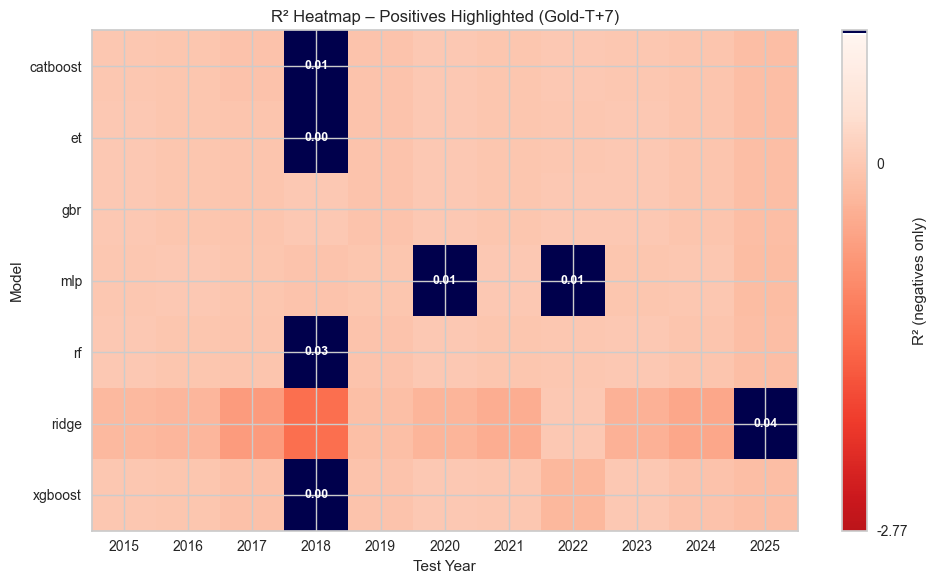

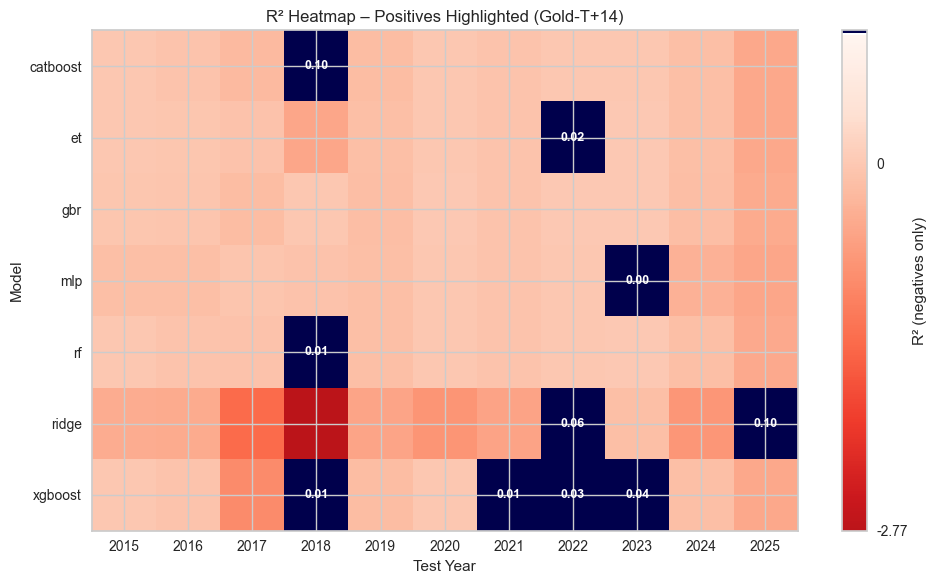

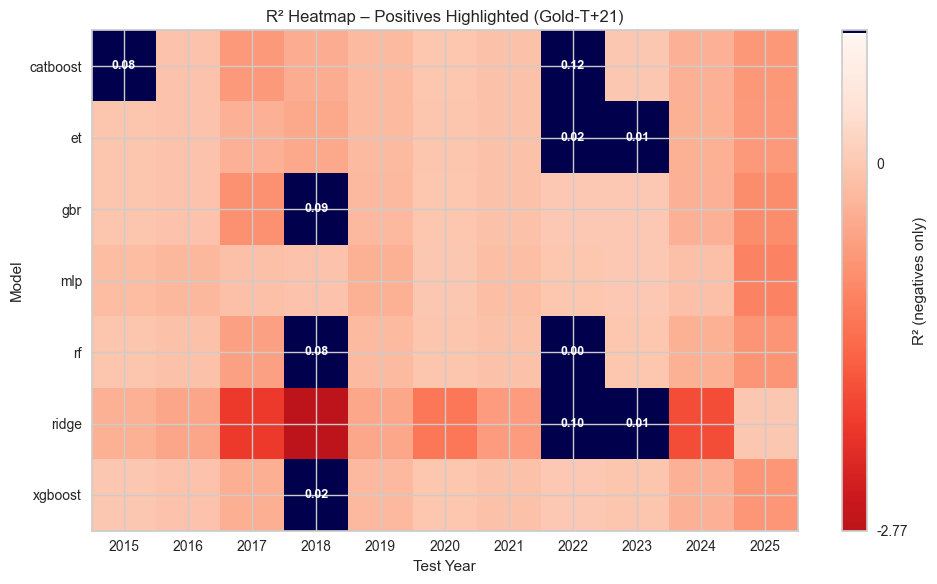

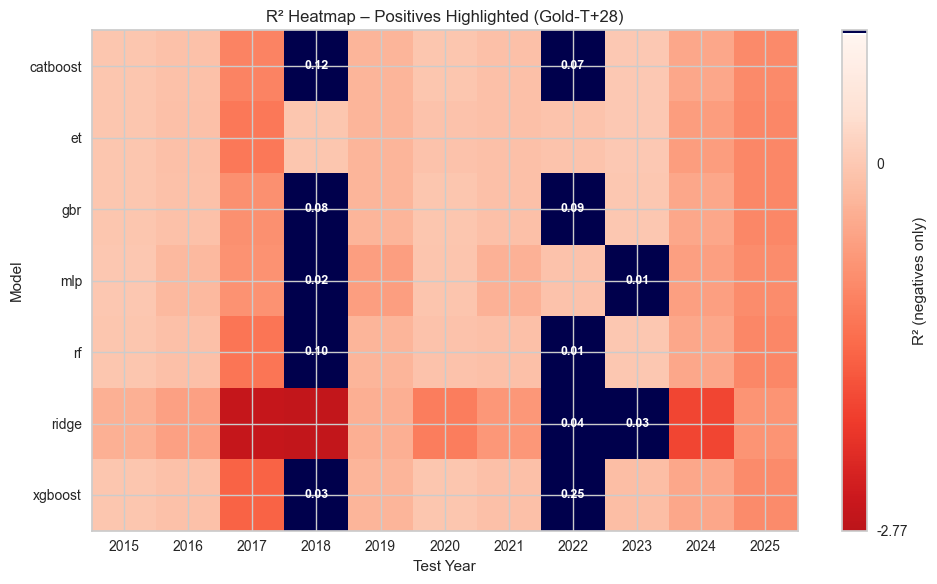

In [99]:
df = reg_full_results_df.copy()
df["R2"] = pd.to_numeric(df["R2"], errors="coerce")

targets = df["Target"].unique()

# ---- GLOBAL COLOR SCALE ---- #
global_neg_min = df[df["R2"] < 0]["R2"].min()   # lowest negative R² in whole dataset
vmin = global_neg_min
vmax = 1                                        # positive placeholder

for tgt in targets:
    sub = df[df["Target"] == tgt]

    mat = sub.pivot_table(
        index="Model",
        columns="Test_Year",
        values="R2",
        aggfunc="mean"
    ).sort_index().sort_index(axis=1)

    # ---- Display matrix ---- #
    disp = mat.copy()
    disp[disp > 0] = 1  # positives become constant marker

    # ---- Custom colormap ---- #
    reds = plt.cm.Reds_r(np.linspace(0.2, 1, 200))    # negative colors
    pos_color = np.array([[0, 0, 0.3, 1]])             # positive color
    white_zero = np.array([[1, 1, 1, 1]])              # middle
    custom_colors = np.vstack([reds, white_zero, pos_color])
    custom_cmap = ListedColormap(custom_colors)

    plt.figure(figsize=(10, 6))
    im = plt.imshow(
        disp,
        aspect="auto",
        cmap=custom_cmap,
        vmin=vmin,     # <-- GLOBAL SCALE
        vmax=vmax      # <-- GLOBAL SCALE
    )

    plt.title(f"R² Heatmap – Positives Highlighted ({tgt})")
    plt.xlabel("Test Year")
    plt.ylabel("Model")

    plt.xticks(range(len(mat.columns)), mat.columns)
    plt.yticks(range(len(mat.index)), mat.index)

    # consistent colorbar
    cbar = plt.colorbar(im)
    cbar.set_label("R² (negatives only)")
    cbar.set_ticks([vmin, 0])
    cbar.set_ticklabels([f"{vmin:.2f}", "0"])

    # annotate positive R²
    for i, model in enumerate(mat.index):
        for j, year in enumerate(mat.columns):
            value = mat.loc[model, year]
            if value > 0:
                plt.text(
                    j, i, f"{value:.2f}",
                    ha="center",
                    va="center",
                    color="white",
                    fontsize=9,
                    fontweight="bold"
                )

    plt.tight_layout()
    plt.show()


For each calendar year, K-means clustering is fitted on standardized return data from all preceding years, and the resulting model is used to classify observations in the out-of-sample test year. Regime instability is quantified using the normalized entropy of the yearly regime distribution, with higher entropy indicating more frequent regime switching within a year.

In [136]:
# --- PREPARE DATA ---
df = data.iloc[:, :-4].copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

returns = df.iloc[:, 1:]
df['Year'] = df['Date'].dt.year
df['Regime'] = pd.NA

years = sorted(df['Year'].unique())

# --- WALK-FORWARD REGIME DETECTION (NO LOOK-AHEAD BIAS) ---
for year in years:

    train_mask = df['Year'] < year
    test_mask = df['Year'] == year

    train = returns.loc[train_mask]
    test = returns.loc[test_mask]

    # Skip years with insufficient data
    if len(train) < 200 or len(test) < 30:
        continue

    # Standardize using training data only
    mean_train = train.mean()
    std_train = train.std(ddof=0).replace(0, 1e-9)

    train_scaled = (train - mean_train).div(std_train)
    test_scaled = (test - mean_train).div(std_train)

    # K-means regime clustering
    kmeans = KMeans(
        n_clusters=3,
        random_state=42,
        n_init=20
    )
    kmeans.fit(train_scaled)

    # Assign regimes to the test year
    df.loc[test_mask, 'Regime'] = kmeans.predict(test_scaled)

# Convert to integer labels
df['Regime'] = df['Regime'].astype('Int64')


# --- REGIME ENTROPY PER YEAR ---
year_counts = (
    df.groupby(['Year', 'Regime'])
      .size()
      .unstack(fill_value=0)
)

year_probs = year_counts.div(year_counts.sum(axis=1), axis=0)

year_counts['entropy'] = year_probs.apply(
    lambda p: entropy(p) / np.log(len(p)),
    axis=1
)

print('\n=== REGIME COUNTS AND NORMALIZED ENTROPY ===\n')
print(year_counts)



=== REGIME COUNTS AND NORMALIZED ENTROPY ===

Regime    0    1    2   entropy
Year                           
2012     92    0  152  0.603125
2013      0  146  102  0.616528
2014     48   35  163  0.791003
2015     67   20  162  0.760456
2016     42  133   72  0.904713
2017      3  153   90  0.652619
2018     56  125   66  0.940984
2019     34  166   48  0.781875
2020     52    7  192  0.574298
2021      4  107  140  0.687288
2022    140   38   72  0.882521
2023     19  112  116  0.829115
2024     15   63  171  0.705465
2025     10   21  146  0.522545


In [141]:
year_counts['entropy'] = year_counts['entropy'].round(3)
year_counts

Regime,0,1,2,entropy
Year,,,,
2012,92,0,152,0.603
2013,0,146,102,0.617
2014,48,35,163,0.791
2015,67,20,162,0.760
2016,42,133,72,0.905
2017,3,153,90,0.653
2018,56,125,66,0.941
2019,34,166,48,0.782
2020,52,7,192,0.574


In [142]:
print(year_counts.to_latex())

\begin{tabular}{lrrrr}
\toprule
Regime & 0 & 1 & 2 & entropy \\
Year &  &  &  &  \\
\midrule
2012 & 92 & 0 & 152 & 0.603000 \\
2013 & 0 & 146 & 102 & 0.617000 \\
2014 & 48 & 35 & 163 & 0.791000 \\
2015 & 67 & 20 & 162 & 0.760000 \\
2016 & 42 & 133 & 72 & 0.905000 \\
2017 & 3 & 153 & 90 & 0.653000 \\
2018 & 56 & 125 & 66 & 0.941000 \\
2019 & 34 & 166 & 48 & 0.782000 \\
2020 & 52 & 7 & 192 & 0.574000 \\
2021 & 4 & 107 & 140 & 0.687000 \\
2022 & 140 & 38 & 72 & 0.883000 \\
2023 & 19 & 112 & 116 & 0.829000 \\
2024 & 15 & 63 & 171 & 0.705000 \\
2025 & 10 & 21 & 146 & 0.523000 \\
\bottomrule
\end{tabular}




=== METRICS BY QUANTILE ===

   quantile  threshold  detected_years              detected_year_list  TP  \
0      0.50   0.760456               5  [2016, 2018, 2019, 2022, 2023]   3   
1      0.55   0.771166               5  [2016, 2018, 2019, 2022, 2023]   3   
2      0.60   0.781875               4        [2016, 2018, 2022, 2023]   3   
3      0.65   0.805495               4        [2016, 2018, 2022, 2023]   3   
4      0.70   0.829115               3              [2016, 2018, 2022]   2   
5      0.75   0.855818               3              [2016, 2018, 2022]   2   
6      0.80   0.882521               2                    [2016, 2018]   1   
7      0.85   0.893617               2                    [2016, 2018]   1   
8      0.90   0.904713               1                          [2018]   1   
9      0.95   0.922848               1                          [2018]   1   

   FP  FN  TN  precision_%    recall_%  false_detection_%       F1_%  
0   2   0   6    60.000000  100.000000  

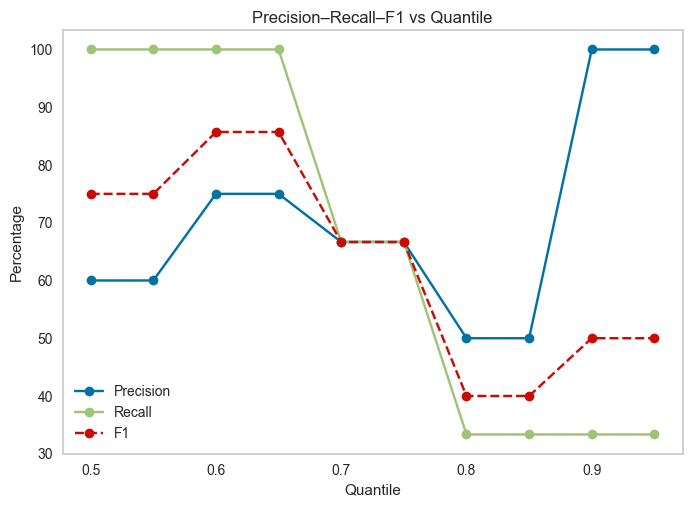


=== OPTIMAL QUANTILE (by F1) ===

Quantile       : 0.6
Entropy thresh : 0.7819
Precision (%)  : 75.0
Recall (%)     : 100.0
F1 (%)         : 85.7

Detected years at optimal quantile:
[2016, 2018, 2022, 2023]


In [109]:
# ----------------------------
# CONFIG
# ----------------------------
model_years = {2018, 2022, 2023}
quantiles = np.arange(0.5, 1.0, 0.05).round(2)

# Use only post-2015 years
subset = year_counts[year_counts.index >= 2015]
all_years = set(subset.index)

# ----------------------------
# METRICS PER QUANTILE
# ----------------------------
results = []

for q in quantiles:
    threshold = subset['entropy'].quantile(q)
    detected_years = set(subset[subset['entropy'] > threshold].index)

    TP = len(detected_years & model_years)
    FP = len(detected_years - model_years)
    FN = len(model_years - detected_years)
    TN = len(all_years - detected_years - model_years)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    fdr = FP / (TP + FP) if (TP + FP) > 0 else 0.0

    results.append({
        'quantile': q,
        'threshold': threshold,
        'detected_years': len(detected_years),
        'detected_year_list': sorted(detected_years),
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'precision_%': precision * 100,
        'recall_%': recall * 100,
        'false_detection_%': fdr * 100
    })

metrics_df = pd.DataFrame(results)

# ----------------------------
# F1 SCORE
# ----------------------------
metrics_df['F1_%'] = (
    2 * metrics_df['precision_%'] * metrics_df['recall_%']
    / (metrics_df['precision_%'] + metrics_df['recall_%'])
).fillna(0)

print('\n=== METRICS BY QUANTILE ===\n')
print(metrics_df)

# ----------------------------
# PLOT: Precision–Recall–F1
# ----------------------------
plt.figure()
plt.plot(metrics_df['quantile'], metrics_df['precision_%'], marker='o', label='Precision')
plt.plot(metrics_df['quantile'], metrics_df['recall_%'], marker='o', label='Recall')
plt.plot(metrics_df['quantile'], metrics_df['F1_%'], marker='o', linestyle='--', label='F1')

plt.xlabel('Quantile')
plt.ylabel('Percentage')
plt.title('Precision–Recall–F1 vs Quantile')
plt.legend()
plt.grid(False)
plt.show()

# ----------------------------
# OPTIMAL QUANTILE
# ----------------------------
best_idx = metrics_df['F1_%'].idxmax()
best_row = metrics_df.loc[best_idx]

print('\n=== OPTIMAL QUANTILE (by F1) ===\n')
print(f'Quantile       : {best_row["quantile"]}')
print(f'Entropy thresh : {best_row["threshold"]:.4f}')
print(f'Precision (%)  : {best_row["precision_%"]:.1f}')
print(f'Recall (%)     : {best_row["recall_%"]:.1f}')
print(f'F1 (%)         : {best_row["F1_%"]:.1f}')

print('\nDetected years at optimal quantile:')
print(best_row['detected_year_list'])


## 4. Classification analysis

In [112]:
from pycaret.classification import *

# ---------------- CONFIG ----------------
targets = ['Gold-T+7','Gold-T+14','Gold-T+21','Gold-T+28']

candidate_models = [
    'ridge',
    'et',
    'rf',
    'catboost',
    'xgboost',
    'mlp'
]

WINDOW_YEARS = 4
MIN_TRAIN_ROWS = 150
SESSION_ID = 123

# ========================================
# DATA PREP
# ========================================
def make_df_cls(data, tgt, targets):
    df = data.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.dropna(subset=[tgt])
    df = df.sort_values('Date').reset_index(drop=True)

    # Binary directional classification
    df['y'] = np.where(df[tgt] > 0, 1, 0)

    # keep only 0 and 1
    df = df[df['y'].isin([0, 1])]

    # date features
    df['year']      = df['Date'].dt.year
    df['month']     = df['Date'].dt.month
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['dayofyear'] = df['Date'].dt.dayofyear

    # remove ALL original target columns, including the active one
    remove_cols = targets  # removes tgt + all others
    df = df.drop(columns=remove_cols, errors='ignore')

    return df


# ========================================
# WALK FORWARD CLASSIFICATION
# ========================================
def yearly_walk_forward_classification(
    model_name: str,
    df: pd.DataFrame,
    target_col: str='y',
    window_years: int=3,
    tuning: bool=True,
):
    df = df.copy()
    years = sorted(df['year'].unique())

    results = []
    preds_log = []

    total_start = time.time()

    # features = all except Date + target
    full_feats = [c for c in df.columns if c not in ['Date', target_col]]

    for test_year in years:

        train_start_year = test_year - window_years
        if train_start_year < years[0]:
            continue

        train = df[(df['year'] >= train_start_year) & (df['year'] < test_year)]
        test  = df[df['year'] == test_year]

        if len(train) < MIN_TRAIN_ROWS or len(test) < 10:
            continue

        # final cleaned view
        train = train[['Date'] + full_feats + [target_col]].dropna()
        test  = test[['Date'] + full_feats + [target_col]].dropna()

        # =========================
        # Must contain both classes
        # =========================
        train_classes = set(train[target_col].unique())
        if not ({0, 1}.issubset(train_classes)):
            print(f"⚠ Skipping {test_year}: training window missing class. Found={train_classes}")
            continue

        try:
            setup(
                data=train.drop(columns=['Date']),
                target=target_col,

                fold=3,
                fold_strategy='timeseries',

                # avoid stratification with time-series
                data_split_stratify=False,

                data_split_shuffle=False,
                fold_shuffle=False,
                remove_outliers=False,
                verbose=False,
                session_id=SESSION_ID
            )

            start_train = time.time()
            base = create_model(model_name, verbose=False)

            if tuning:
                base = tune_model(base, optimize='Accuracy', verbose=False)

            final_m = finalize_model(base)
            train_time = time.time() - start_train

            preds_df = predict_model(
                final_m,
                data=test.drop(columns=['Date']),
                verbose=False
            )

            # ====================================
            # Detect prediction label column safely
            # ====================================
            if 'prediction_label' in preds_df.columns:
                pred_col = 'prediction_label'
            else:
                pred_cols = [
                    c for c in preds_df.columns
                    if ('prediction' in c.lower()) and ('score' not in c.lower())
                ]
                if not pred_cols:
                    raise KeyError(
                        f"No valid prediction label column found. "
                        f"Available={list(preds_df.columns)}"
                    )
                pred_col = pred_cols[0]

            preds = preds_df[pred_col].values
            actual = test[target_col].values

            acc   = accuracy_score(actual, preds)
            bacc  = balanced_accuracy_score(actual, preds)
            f1    = f1_score(actual, preds, average='macro')

            # baseline = majority direction
            maj = pd.Series(actual).mode()[0]
            baseline_acc = np.mean(actual == maj)
            skill = (acc - baseline_acc) / (1 - baseline_acc) if baseline_acc < 1 else 0

            results.append({
                'Model'         : model_name,
                'Target'        : tgt,
                'Test_Year'     : test_year,
                'Train_Years'   : f"{train_start_year}–{test_year-1}",
                'Train_Rows'    : len(train),
                'Test_Rows'     : len(test),
                'Train_Time_Seconds': round(train_time, 4),

                'Accuracy'      : acc,
                'Balanced_Acc'  : bacc,
                'F1'            : f1,
                'Baseline_Acc'  : baseline_acc,
                'Skill'         : skill,
            })

            pred_log = pd.DataFrame({
                'Date'       : test['Date'].values,
                'Actual'     : actual,
                'Predicted'  : preds,
                'Test_Year'  : test_year,
                'Model'      : model_name,
                'Target'     : tgt
            })
            preds_log.append(pred_log)

        except Exception:
            print(f"\n⚠ ERROR: model={model_name}, Test_Year={test_year}")
            traceback.print_exc()

    total_run = time.time() - total_start

    results_df = pd.DataFrame(results)
    preds_df = pd.concat(preds_log, ignore_index=True) if preds_log else pd.DataFrame()

    return results_df, preds_df, total_run


# ========================================
# MAIN EXECUTION
# ========================================
cls_summary = []
all_results_df = []
all_preds_df = []

for tgt in targets:
    print(f"\n============== TARGET: {tgt} ==============")

    df_target = make_df_cls(data, tgt, targets)

    for m in candidate_models:
        wf, preds, total_time = yearly_walk_forward_classification(
            model_name=m,
            df=df_target,
            target_col='y',
            window_years=WINDOW_YEARS,
            tuning=True,
        )

        if len(wf):
            all_results_df.append(wf)
            all_preds_df.append(preds)

            avg_acc   = wf['Accuracy'].mean()
            avg_bacc  = wf['Balanced_Acc'].mean()
            avg_f1    = wf['F1'].mean()
            avg_skill = wf['Skill'].mean()
            avg_ttime = wf['Train_Time_Seconds'].mean()
        else:
            avg_acc = avg_bacc = avg_f1 = avg_skill = avg_ttime = None

        cls_summary.append({
            'Target'                : tgt,
            'Model'                 : m,
            'Avg_Accuracy'          : avg_acc,
            'Avg_BalAcc'            : avg_bacc,
            'Avg_F1'                : avg_f1,
            'Avg_Skill'             : avg_skill,
            'Avg_Folds'             : len(wf),
            'Avg_Train_Time_Seconds': avg_ttime,
            'Total_Run_Time_Seconds': round(total_time,3),
        })

# =======================
# Consolidate outputs
# =======================
summary_df = pd.DataFrame(cls_summary)
full_results = pd.concat(all_results_df, ignore_index=True)
full_preds   = pd.concat(all_preds_df, ignore_index=True)

print("\n============== SUMMARY TABLE ==============\n")
print(summary_df)

print("\n============== FULL ROLLING RESULTS ==============\n")
print(full_results)

print("\n============== FULL PREDICTION LOGS ==============\n")
print(full_preds.head())



============== TARGET: Gold-T+7 ==============

============== TARGET: Gold-T+14 ==============

============== TARGET: Gold-T+21 ==============

============== TARGET: Gold-T+28 ==============

============== SUMMARY TABLE ==============

       Target     Model  Avg_Accuracy  Avg_BalAcc    Avg_F1  Avg_Skill  \
0    Gold-T+7     ridge      0.524382    0.528035  0.486917  -0.156436   
1    Gold-T+7        et      0.500310    0.514648  0.408929  -0.234683   
2    Gold-T+7        rf      0.526902    0.513702  0.403923  -0.156879   
3    Gold-T+7  catboost      0.535595    0.532755  0.493935  -0.128770   
4    Gold-T+7   xgboost      0.478505    0.511198  0.438042  -0.279846   
5    Gold-T+7       mlp      0.536609    0.511972  0.379209  -0.104560   
6   Gold-T+14     ridge      0.534165    0.558088  0.487920  -0.195097   
7   Gold-T+14        et      0.537826    0.525368  0.415789  -0.140236   
8   Gold-T+14        rf      0.540505    0.521454  0.400157  -0.159709   
9   Gold-T+14  catb

In [113]:
full_preds['Right'] = (full_preds['Actual'] == full_preds['Predicted']).astype(int)

In [114]:
summary_df.to_csv('./result/classification_summary.csv')
full_results.to_csv('./result/classification_full_results.csv')
full_preds.to_csv('./result/classification_full_preds.csv')

In [120]:
full_results

,Model,Target,Test_Year,Train_Years,Train_Rows,Test_Rows,Train_Time_Seconds,Accuracy,Balanced_Acc,F1,Baseline_Acc,Skill
0,ridge,Gold-T+7,2015,2011–2014,989,249,7.3764,0.502008,0.489667,0.489484,0.570281,-0.158879
1,ridge,Gold-T+7,2016,2012–2015,987,247,2.8249,0.518219,0.539328,0.497633,0.542510,-0.053097
2,ridge,Gold-T+7,2017,2013–2016,990,246,3.0664,0.593496,0.585816,0.585580,0.573171,0.047619
3,ridge,Gold-T+7,2018,2014–2017,988,247,2.8687,0.425101,0.410229,0.343675,0.522267,-0.203390
4,ridge,Gold-T+7,2019,2015–2018,989,248,3.0217,0.604839,0.546460,0.535190,0.608871,-0.010309
...,...,...,...,...,...,...,...,...,...,...,...,...
259,mlp,Gold-T+28,2021,2017–2020,992,251,8.2173,0.454183,0.437412,0.425591,0.545817,-0.201754
260,mlp,Gold-T+28,2022,2018–2021,997,250,7.0225,0.464000,0.466974,0.380043,0.504000,-0.080645
261,mlp,Gold-T+28,2023,2019–2022,1000,247,7.9194,0.534413,0.493231,0.356027,0.542510,-0.017699
262,mlp,Gold-T+28,2024,2020–2023,999,249,5.9119,0.791165,0.500000,0.441704,0.791165,0.000000


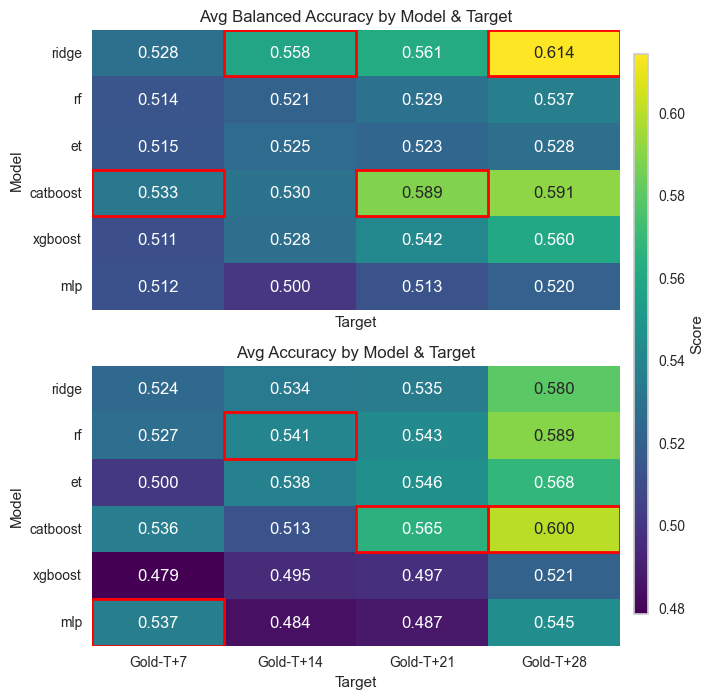

In [150]:
from matplotlib.patches import Rectangle

# ----------------------------
# Pivot tables
# ----------------------------
pivot_bal = full_results.pivot_table(
    index='Model',
    columns='Target',
    values='Balanced_Acc',
    aggfunc='mean'
)

pivot_acc = full_results.pivot_table(
    index='Model',
    columns='Target',
    values='Accuracy',
    aggfunc='mean'
)

# ----------------------------
# Enforce row/column order
# ----------------------------
row_order = ['ridge', 'rf', 'et', 'catboost', 'xgboost', 'mlp']
col_order = ['Gold-T+7', 'Gold-T+14', 'Gold-T+21', 'Gold-T+28']

# keep only those that exist (prevents KeyError)
row_order = [r for r in row_order if r in pivot_bal.index]
col_order = [c for c in col_order if c in pivot_bal.columns]

pivot_bal = pivot_bal.reindex(index=row_order, columns=col_order)
pivot_acc = pivot_acc.reindex(index=row_order, columns=col_order)

# optional: consistent color scale across both heatmaps
vals = pd.concat([pivot_bal.stack(), pivot_acc.stack()]).dropna()
vmin = float(vals.min()) if len(vals) else 0.0
vmax = float(vals.max()) if len(vals) else 1.0

# ----------------------------
# Create figure with extra space on the right
# ----------------------------
fig, axes = plt.subplots(
    2, 1,
    figsize=(7, 8),
    sharex=True,
    gridspec_kw={'right': 0.88}
)

# ----------------------------
# Top heatmap: Balanced Accuracy
# ----------------------------
hm1 = sns.heatmap(
    pivot_bal,
    annot=True,
    fmt='.3f',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    cbar=False,
    ax=axes[0]
)
axes[0].set_title('Avg Balanced Accuracy by Model & Target')
axes[0].set_ylabel('Model')

# Highlight best model per target (Balanced Accuracy)
for col_idx, col in enumerate(pivot_bal.columns):
    if pivot_bal[col].notna().any():
        row_label = pivot_bal[col].idxmax()
        y = pivot_bal.index.get_loc(row_label)
        axes[0].add_patch(Rectangle((col_idx, y), 1, 1, fill=False, edgecolor='red', lw=2))

# ----------------------------
# Bottom heatmap: Accuracy
# ----------------------------
hm2 = sns.heatmap(
    pivot_acc,
    annot=True,
    fmt='.3f',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    cbar=False,
    ax=axes[1]
)
axes[1].set_title('Avg Accuracy by Model & Target')
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Model')

# Highlight best model per target (Accuracy)
for col_idx, col in enumerate(pivot_acc.columns):
    if pivot_acc[col].notna().any():
        row_label = pivot_acc[col].idxmax()
        y = pivot_acc.index.get_loc(row_label)
        axes[1].add_patch(Rectangle((col_idx, y), 1, 1, fill=False, edgecolor='red', lw=2))

# ----------------------------
# Shared colorbar
# ----------------------------
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cbar = fig.colorbar(hm1.collections[0], cax=cax)
cbar.set_label('Score')

plt.show()


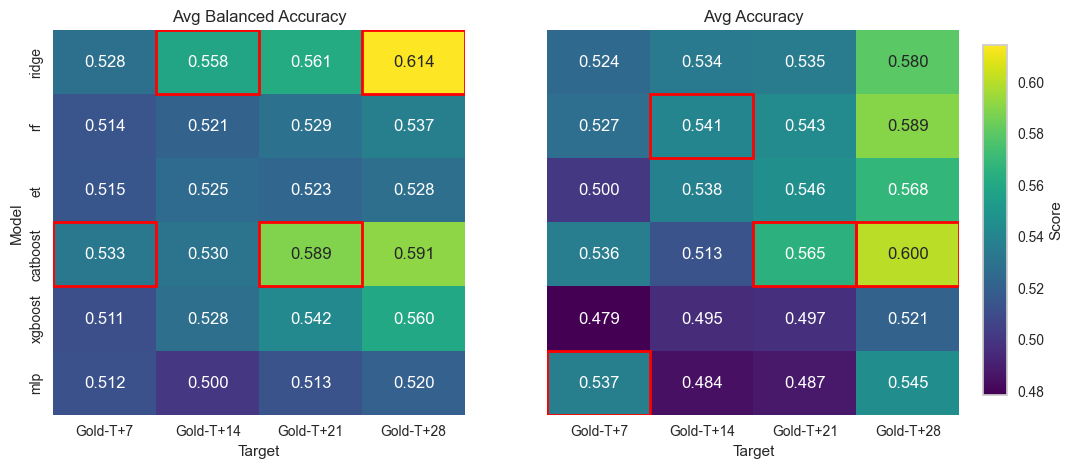

In [151]:
from matplotlib.patches import Rectangle

# ----------------------------
# Create figure (LEFT–RIGHT)
# ----------------------------
fig, axes = plt.subplots(
    1, 2,
    figsize=(12, 5),
    sharey=True,
    gridspec_kw={'right': 0.88}
)

# ----------------------------
# LEFT: Balanced Accuracy
# ----------------------------
hm1 = sns.heatmap(
    pivot_bal,
    annot=True,
    fmt='.3f',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    cbar=False,
    ax=axes[0]
)
axes[0].set_title('Avg Balanced Accuracy')
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Model')

# Highlight best model per target (Balanced Accuracy)
for col_idx, col in enumerate(pivot_bal.columns):
    if pivot_bal[col].notna().any():
        row_label = pivot_bal[col].idxmax()
        y = pivot_bal.index.get_loc(row_label)
        axes[0].add_patch(
            Rectangle((col_idx, y), 1, 1, fill=False, edgecolor='red', lw=2)
        )

# ----------------------------
# RIGHT: Accuracy
# ----------------------------
hm2 = sns.heatmap(
    pivot_acc,
    annot=True,
    fmt='.3f',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    cbar=False,
    ax=axes[1]
)
axes[1].set_title('Avg Accuracy')
axes[1].set_xlabel('Target')
axes[1].set_ylabel('')  # shared y-axis

# Highlight best model per target (Accuracy)
for col_idx, col in enumerate(pivot_acc.columns):
    if pivot_acc[col].notna().any():
        row_label = pivot_acc[col].idxmax()
        y = pivot_acc.index.get_loc(row_label)
        axes[1].add_patch(
            Rectangle((col_idx, y), 1, 1, fill=False, edgecolor='red', lw=2)
        )

# ----------------------------
# Shared colorbar
# ----------------------------
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cbar = fig.colorbar(hm1.collections[0], cax=cax)
cbar.set_label('Score')

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()



In [144]:
baseline = full_preds.copy()

# Dumb predictions
baseline['Pred_UP'] = 1
baseline['Pred_DOWN'] = 0

# Correctness
baseline['Right_UP'] = (baseline['Actual'] == baseline['Pred_UP']).astype(int)
baseline['Right_DOWN'] = (baseline['Actual'] == baseline['Pred_DOWN']).astype(int)

# Compute per (Model, Target)
per_model_target = (
    baseline.groupby(['Model','Target'])[['Right','Right_UP','Right_DOWN']]
    .mean()
    .reset_index()
)

# Best dumb baseline
per_model_target['Best_Dumb'] = per_model_target[['Right_UP','Right_DOWN']].max(axis=1)

per_model_target['Rel_Acc'] = per_model_target['Right'] - per_model_target['Best_Dumb']

print("\n========= HIT-RATES PER MODEL & TARGET =========")
print(per_model_target)



========= HIT-RATES PER MODEL & TARGET =========
       Model     Target     Right  Right_UP  Right_DOWN  Best_Dumb   Rel_Acc
0   catboost  Gold-T+14  0.515402  0.433884    0.566116   0.566116 -0.050714
1   catboost  Gold-T+21  0.560105  0.431630    0.568370   0.568370 -0.008264
2   catboost  Gold-T+28  0.592412  0.430128    0.569872   0.569872  0.022539
3   catboost   Gold-T+7  0.532682  0.437265    0.562735   0.562735 -0.030053
4         et  Gold-T+14  0.531555  0.433884    0.566116   0.566116 -0.034560
5         et  Gold-T+21  0.539068  0.431630    0.568370   0.568370 -0.029301
6         et  Gold-T+28  0.559354  0.430128    0.569872   0.569872 -0.010518
7         et   Gold-T+7  0.501127  0.437265    0.562735   0.562735 -0.061608
8        mlp  Gold-T+14  0.479715  0.433884    0.566116   0.566116 -0.086401
9        mlp  Gold-T+21  0.485725  0.431630    0.568370   0.568370 -0.082645
10       mlp  Gold-T+28  0.542449  0.430128    0.569872   0.569872 -0.027423
11       mlp   Gold-T+7  0

In [154]:
# Models that beat the best dumb baseline
better_than_dumb = per_model_target[
    per_model_target['Right'] > per_model_target['Best_Dumb']
].reset_index(drop=True)

print("\n========= MODELS THAT BEAT BEST DUMB BASELINE =========")
print(better_than_dumb)



========= MODELS THAT BEAT BEST DUMB BASELINE =========
      Model     Target     Right  Right_UP  Right_DOWN  Best_Dumb   Rel_Acc
0  catboost  Gold-T+28  0.592412  0.430128    0.569872   0.569872  0.022539
1        rf  Gold-T+28  0.581518  0.430128    0.569872   0.569872  0.011645
2     ridge  Gold-T+28  0.576634  0.430128    0.569872   0.569872  0.006762


In [146]:
from itertools import combinations
import pandas as pd

models = sorted(full_preds['Model'].unique())
targets = sorted(full_preds['Target'].unique())

all_outcomes = []

for tgt in targets:
    df_t = full_preds[full_preds['Target'] == tgt].copy()

    for r in range(2, len(models)+1):
        for combo in combinations(models, r):
            
            sub = (
                df_t[df_t['Model'].isin(combo)]
                .pivot_table(
                    index=['Date'],
                    columns='Model',
                    values='Predicted'
                )
            )

            # ensure no empty combos (rare but safe)
            if sub.empty:
                continue

            # majority vote
            sub['Pred'] = (sub.mean(axis=1) >= 0.5).astype(int)
            sub = sub.reset_index()

            # attach actuals
            actuals = df_t[['Date','Actual']].drop_duplicates()
            sub = sub.merge(actuals, on='Date', how='left')

            # ensemble hit
            sub['Right'] = (sub['Pred'] == sub['Actual']).astype(int)
            ensemble_hit = sub['Right'].mean()

            # dumb baseline
            sub['UP'] = (sub['Actual'] == 1).astype(int)
            sub['DOWN'] = (sub['Actual'] == 0).astype(int)

            up_hit   = sub['UP'].mean()
            down_hit = sub['DOWN'].mean()
            best_dumb = max(up_hit, down_hit)
            rel_acc = ensemble_hit - best_dumb

            all_outcomes.append({
                'Target': tgt,
                'Models': combo,
                'N_Models': len(combo),
                'Ensemble_Hit': ensemble_hit,
                'Always_UP': up_hit,
                'Always_DOWN': down_hit,
                'Best_Dumb': best_dumb,
                'Rel_Acc_vs_Dumb': rel_acc,
                'Beat_Dumb': ensemble_hit > best_dumb
            })

subset_results = pd.DataFrame(all_outcomes)

print("\n========= ALL SUBSET ENSEMBLES PER TARGET =========")
print(subset_results.sort_values(['Target','Ensemble_Hit'], ascending=[True,False]))



========= ALL SUBSET ENSEMBLES PER TARGET =========
        Target                   Models  N_Models  Ensemble_Hit  Always_UP  \
22   Gold-T+14    (catboost, rf, ridge)         3      0.552592   0.433884   
16   Gold-T+14       (catboost, et, rf)         3      0.551089   0.433884   
28   Gold-T+14          (et, rf, ridge)         3      0.542825   0.433884   
34   Gold-T+14     (rf, ridge, xgboost)         3      0.532307   0.433884   
23   Gold-T+14  (catboost, rf, xgboost)         3      0.528926   0.433884   
..         ...                      ...       ...           ...        ...   
182   Gold-T+7           (mlp, xgboost)         2      0.471074   0.437265   
184   Gold-T+7            (rf, xgboost)         2      0.469947   0.437265   
185   Gold-T+7         (ridge, xgboost)         2      0.469572   0.437265   
175   Gold-T+7      (catboost, xgboost)         2      0.467318   0.437265   
179   Gold-T+7            (et, xgboost)         2      0.454170   0.437265   

     Alway

In [149]:
subset_results[subset_results['Rel_Acc_vs_Dumb'] > 0].sort_values(by='Rel_Acc_vs_Dumb', ascending=False)

,Target,Models,N_Models,Ensemble_Hit,Always_UP,Always_DOWN,Best_Dumb,Rel_Acc_vs_Dumb,Beat_Dumb
136,Gold-T+28,"(catboost, rf, ridge)",3,0.619835,0.430128,0.569872,0.569872,0.049962,True
142,Gold-T+28,"(et, rf, ridge)",3,0.613449,0.430128,0.569872,0.569872,0.043576,True
164,Gold-T+28,"(catboost, et, mlp, rf, ridge)",5,0.607062,0.430128,0.569872,0.569872,0.037190,True
145,Gold-T+28,"(mlp, rf, ridge)",3,0.607062,0.430128,0.569872,0.569872,0.037190,True
149,Gold-T+28,"(catboost, et, mlp, rf)",4,0.602930,0.430128,0.569872,0.569872,0.033058,True
167,Gold-T+28,"(catboost, et, rf, ridge, xgboost)",5,0.601427,0.430128,0.569872,0.569872,0.031555,True
159,Gold-T+28,"(et, mlp, rf, ridge)",4,0.600676,0.430128,0.569872,0.569872,0.030804,True
116,Gold-T+28,"(catboost, rf)",2,0.598798,0.430128,0.569872,0.569872,0.028926,True
169,Gold-T+28,"(et, mlp, rf, ridge, xgboost)",5,0.598047,0.430128,0.569872,0.569872,0.028174,True
152,Gold-T+28,"(catboost, et, rf, ridge)",4,0.597295,0.430128,0.569872,0.569872,0.027423,True
